In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, sem, t

In [2]:
# # Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [3]:
conn = sqlite3.connect('../data/nba.db')

The code below extracts away team plus/minus (points scored - opponent points scored), which is equivalent to margin of victory. I chose away team margin of victory because the resulting value is negative and can be directly compared to home team point spreads.

In [4]:
mov = pd.read_sql('''
    SELECT SEASON, PLUS_MINUS
    FROM team_game_stats
    JOIN games
    ON team_game_stats.GAME_ID IS games.ID
    AND team_game_stats.TEAM_ID = games.AWAY_TEAM_ID''', conn)

The code below extracts home team point spreads from the database.

In [5]:
spread = pd.read_sql('''
    SELECT SEASON, HOME_SPREAD
    FROM games
    JOIN betting ON games.ID IS betting.GAME_ID''', conn).dropna()

Oddsmakers are very good at their jobs. The difference between average away team margin of victory and home team point spread is only a tenth of a point.

In [6]:
n = len(mov)
print('The average away team margin of victory is {:.2f} in {:d} games'.format(mov.PLUS_MINUS.mean(), n))
print('The average home team point spread is {:.2f}'.format(spread.HOME_SPREAD.mean()))

The average away team margin of victory is -3.33 in 32629 games
The average home team point spread is -3.41


The distribution of home point spreads is bimodal because oddsmakers very rarely set a point spread of zero (a "pick-em" game).

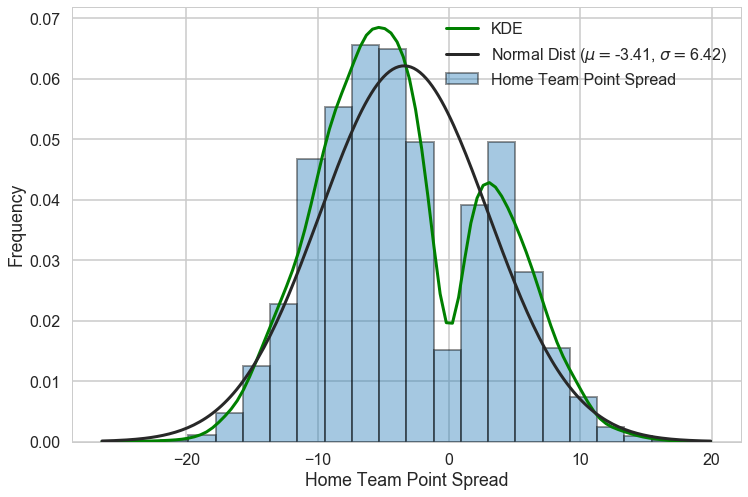

In [7]:
mu, sigma = spread.HOME_SPREAD.mean(), spread.HOME_SPREAD.std()
plt.figure(figsize=(12, 8))
ax = sns.distplot(spread.HOME_SPREAD, fit=norm, kde=True, bins=20,
                  kde_kws={'label': 'KDE', 'color': 'green', 'linewidth': 3},
                  hist_kws={'label': 'Home Team Point Spread', 'edgecolor': 'k', 'linewidth': 2},
                  fit_kws={'label': 'Normal Dist ($\mu=${0:.2f}, $\sigma=${1:.2f})'.format(mu, sigma),
                           'linewidth': 3})
ax.legend()
plt.xlabel('Home Team Point Spread')
plt.ylabel('Frequency')
plt.show()

The distribution of actual point differences is not quite as severe, but there is still a drop at zero because games cannot end in ties.

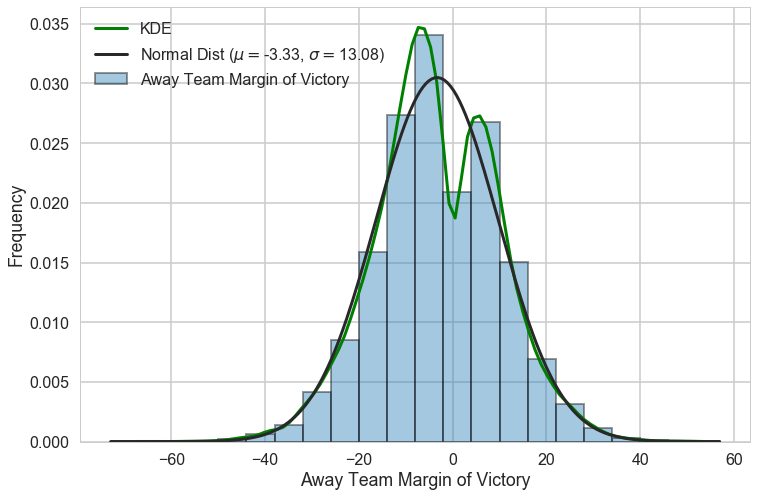

In [8]:
mu, sigma = mov.PLUS_MINUS.mean(), mov.PLUS_MINUS.std()
plt.figure(figsize=(12, 8))
ax = sns.distplot(mov.PLUS_MINUS, fit=norm, kde=True, bins=20,
                  kde_kws={'label': 'KDE', 'color': 'green', 'linewidth': 3},
                  hist_kws={'label': 'Away Team Margin of Victory', 'edgecolor': 'k', 'linewidth': 2},
                  fit_kws={'label': 'Normal Dist ($\mu=${0:.2f}, $\sigma=${1:.2f})'.format(mu, sigma),
                           'linewidth': 3})
ax.legend()
plt.xlabel('Away Team Margin of Victory')
plt.ylabel('Frequency')
plt.show()

The idea of home court advantage is nothing new, but I wanted to calculate the probability of getting the observed advantage assuming a null hypothesis that there is no home court advantage. I will use a two-tailed test because I want to test the probability of getting a sample mean this extreme above or below the assumed population mean of zero (no home court advantage). First I calculated the standard error.

In [9]:
# Calculate standard error
serr = sem(mov.PLUS_MINUS)
print(serr)

0.0724288134688


The code below simply verifies the standard error calculation.

In [10]:
# Verify standard error calculation
print(sigma / np.sqrt(n) - serr)

0.0


Next I calculated the z-score. The sample mean is more than 46 standard errors from the assumed population mean. This is such a large value because the sample size is so large. The numerator only has the sample mean because the assumed population mean is zero.

In [11]:
z = abs(mu) / serr
print(z)

46.0440621915


There is zero probability of getting this sample mean by chance if the true population mean is actually zero. Therefore, we can safely conclude that home court advantage does in fact exist.

In [12]:
print(norm.sf(z) * 2) # multiply by 2 for a two-tailed test

0.0


The code below calculates average away team margin of victory and home team point spread per season.

In [13]:
avg_mov = pd.read_sql('''
    SELECT SEASON, AVG(PLUS_MINUS) AS AVG_PLUS_MINUS
    FROM team_game_stats
    JOIN games
    ON team_game_stats.GAME_ID IS games.ID
    AND team_game_stats.TEAM_ID = games.AWAY_TEAM_ID
    GROUP BY SEASON''', conn)
avg_spread = pd.read_sql('''
    SELECT SEASON, AVG(HOME_SPREAD) AS AVG_HOME_SPREAD
    FROM games
    JOIN betting ON games.ID IS betting.GAME_ID
    GROUP BY SEASON''', conn).dropna()

Both away team margin of victory and home team point spreads have been decreasing in magnitude in recent years. I wanted to calculate the probability of this happening by chance or if home court advantage has been diminishing in recent seasons.

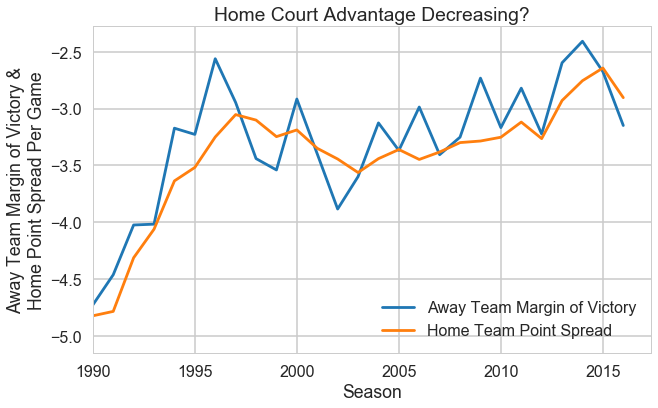

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(avg_mov.SEASON, avg_mov.AVG_PLUS_MINUS, label='Away Team Margin of Victory')
plt.plot(avg_spread.SEASON, avg_spread.AVG_HOME_SPREAD, label='Home Team Point Spread')
plt.xlabel('Season')
plt.ylabel('Away Team Margin of Victory &\nHome Point Spread Per Game')
plt.title('Home Court Advantage Decreasing?')
plt.xlim(1990)
plt.legend()
plt.show()

Prior to 2013, home teams won by an average of 3.4 points, but have only won by 2.7 points since.

In [15]:
recent_mov = mov.loc[mov.SEASON >= 2013, 'PLUS_MINUS']
past_mov = mov.loc[mov.SEASON < 2013, 'PLUS_MINUS']
recent_mu = recent_mov.mean()
past_mu = past_mov.mean()
print(recent_mu)
print(past_mu)

-2.70691056911
-3.44642534916


The standard error for recent seasons is much higher than that calculated above for all seasons.

In [16]:
# Calculate standard error
serr = sem(recent_mov)
print(serr)

0.191566298702


This leads to a z-score of 3.86 assuming the population mean is the average margin of victory prior to 2013. This is still a high z-score, but nowhere near as high as the z-score calculated above.

In [17]:
z = abs(recent_mu - past_mu) / serr
print(z)

3.86035949469


There is less than a 1% probability of getting this sample mean by chance if the true population mean is the average margin of victory prior to 2013. Therefore, we can safely conclude that home court advantage has changed in recent seasons.

In [18]:
print(norm.sf(z) * 2) # multiply by 2 for a two-tailed test

0.000113220329438


Using a t-test also produces a probability near zero.

In [19]:
print(t.sf(z, n-1) * 2) # multiply by 2 for a two-tailed test

0.000113438431099


The critical z-score for a 95% confidence interval is about 1.96. This means we are confident there is a 95% probability that the population mean falls within 1.96 standard errors of the sample mean.

In [20]:
zcrit = norm.ppf(0.975) # 97.5% for a two-tailed 95% confidence interval
print(zcrit)

1.95996398454


Converting this to points, we are confident there is a 95% probability that the true population home court advantage since 2013 is within 0.375 points of the observed sample mean of -2.71 points.

In [21]:
d = serr * zcrit
print(d)

0.375463046108


This yields a 95% confidence interval ranging from -3.08 points to -2.33 points, which does not contain the home court advantage prior to 2013.

In [22]:
print((recent_mu-d, recent_mu+d))

(-3.0823736152137813, -2.3314475229976011)


This can also be calculated with the interval method built into scipy.

In [23]:
print(norm.interval(0.95, loc=recent_mu, scale=serr))

(-3.0823736152137813, -2.3314475229976011)
